In [1]:
import os
import sys
import glob
from collections import defaultdict, Counter
from functools import reduce, partial
from multiprocessing import Pool
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from scipy.stats import bootstrap, binom_test
from statsmodels.stats.multitest import multipletests
from scipy.spatial.distance import cosine, euclidean
from Bio import SeqIO
import tqdm

from pymutspec.draw import plot_mutspec12, plot_mutspec192
from pymutspec.annotation import rev_comp, CodonAnnotation, transcriptor, mutations_summary
from pymutspec.io import read_rates
from pymutspec.constants import possible_sbs192, possible_sbs12

In [2]:
def complete_sbs192_columns(df: pd.DataFrame):
    df = df.copy()
    if len(df.columns) != 192:
        for sbs192 in set(possible_sbs192).difference(df.columns.values):
            df[sbs192] = 0.
    df = df[possible_sbs192]
    return df


def jackknife_spectra_sampling(obs: pd.DataFrame, exp: pd.DataFrame, frac=0.5, n=1000):
    if len(obs.columns) == 192 and (obs.columns == possible_sbs192).all() and (exp.columns == possible_sbs192).all():
        assert obs.index.names == ["RefNode", "AltNode"]
        assert exp.index.names == ["Node"]
        altnodes  = obs.index.get_level_values(1).values
        obs_edges = obs
        freqs_nodes = exp
        obs_edges.index = obs_edges.index.reorder_levels(order=["AltNode", "RefNode"])
        freqs_nodes.index.name = "RefNode"
    else:
        altnodes = obs.AltNode.unique()
        obs_edges = obs.groupby(["AltNode", "RefNode", "Mut"]).ProbaFull.sum().unstack()
        obs_edges = complete_sbs192_columns(obs_edges)
        freqs_nodes = exp.rename(columns={"Node": "RefNode"}).groupby(["RefNode", "Mut"]).Proba.sum().unstack()
        freqs_nodes = complete_sbs192_columns(freqs_nodes)

    edges_sample_size = int(len(altnodes) * frac)
    spectra = []
    for _ in range(n):
        altnodes_sample = np.random.choice(altnodes, edges_sample_size, False)
        obs_sample = obs_edges.loc[altnodes_sample].reset_index(0, drop=True)
        exp_sample = freqs_nodes.loc[obs_sample.index]
        
        obs_sample_cnt = obs_sample.sum()
        exp_sample_cnt = exp_sample.sum()

        assert (obs_sample_cnt.index == exp_sample_cnt.index).all()

        sample_spectra = obs_sample_cnt / exp_sample_cnt
        spectra.append(sample_spectra)

    return pd.DataFrame(spectra).fillna(0.)


def collapse_sbs192(df: pd.DataFrame, to=12):
    assert (df.columns == possible_sbs192).all()
    df = df.copy()
    if to == 12:
        for sbs192 in possible_sbs192:
            sbs12 = sbs192[2:5]
            if sbs12 in df.columns.values:
                df[sbs12] += df[sbs192]
            else:
                df[sbs12] = df[sbs192]

        return df[possible_sbs12]
    else:
        raise NotImplementedError()


def calc_edgewise_spectra(obs: pd.DataFrame, exp: pd.DataFrame, nmtypes_cutoff=16, nobs_cuttof=20, collapse_to_12=False, scale=True):
    if len(obs.columns) == 192 and (obs.columns == possible_sbs192).all() and (exp.columns == possible_sbs192).all():
        assert obs.index.names == ["RefNode", "AltNode"]
        assert exp.index.names == ["Node"]
        obs_edges = obs
        freqs_nodes = exp
        freqs_nodes.index.name = "RefNode"
    else:
        obs_edges = obs.groupby(["RefNode", "AltNode", "Mut"]).ProbaFull.sum().unstack()
        obs_edges = complete_sbs192_columns(obs_edges)
        freqs_nodes = exp.groupby(["Node", "Mut"]).Proba.sum().unstack()
        freqs_nodes.index.name = "RefNode"
        freqs_nodes = complete_sbs192_columns(freqs_nodes)

    if not collapse_to_12:
        obs_edges = obs_edges[((obs_edges > 0).sum(axis=1) >= nmtypes_cutoff) & (obs_edges.sum(axis=1) > nobs_cuttof)]
    
    edges_df = obs_edges.index.to_frame(False)

    freqs_edges = edges_df.merge(freqs_nodes, on="RefNode")\
        .set_index(["RefNode", "AltNode"])[possible_sbs192]
    
    assert (obs_edges.columns == freqs_edges.columns).all()
    assert (obs_edges.index == freqs_edges.index).all()

    if collapse_to_12:
        obs_edges   = collapse_sbs192(obs_edges, to=12)
        freqs_edges = collapse_sbs192(freqs_edges, to=12)

    spectra = (obs_edges / freqs_edges).replace(np.inf, 0.).fillna(0.)
    if scale:
        spectra = (spectra.T / spectra.T.sum(axis=0)).T

    spectra = spectra.fillna(0)
    assert not (spectra == np.inf).any().any()
    assert not (spectra.isna()).any().any()
    return spectra


def assign_cat(p: float, interval=0.1):
    if interval < 0.01:
        raise NotImplementedError
    
    left = p // interval / (1 / interval)
    right = left + interval
    if interval >= 0.1:
        return f"{left:.1f}_{right:.1f}"
    else:
        return f"{left:.2f}_{right:.2f}"


def get_cossim(a: pd.DataFrame, b: pd.DataFrame):
    assert (a.columns == b.columns).all()
    
    common_index = a.index.intersection(b.index)
    if len(common_index) == 0:
        return pd.Series()
    
    a = a.loc[common_index]
    b = b.loc[common_index]

    dotprod = (a * b).sum(axis=1)
    a_norm = (a ** 2).sum(axis=1) ** 0.5
    b_norm = (b ** 2).sum(axis=1) ** 0.5
    cossim = dotprod / (a_norm * b_norm)
    return cossim

In [70]:
coda = CodonAnnotation(2)

## Random species trees

### 12  all sites

In [102]:
nmuttypes = 12
param_rates = "_all_positions"

data_rec  = []
data_gt  = []
for d in tqdm.tqdm(glob.glob("../data/alisim/spectra_reconstructed_sp" + param_rates + "/*")):
    elabel = d.split("/")[-1]
    path_to_rec = os.path.join(d, "mutspec_tables/ms{}{}_iqtree.tsv")
    path_to_gt = f"../data/alisim/spectra_groundtruth_sp{param_rates}/{elabel}/mutspec{nmuttypes}.tsv"
    
    if not os.path.exists(path_to_gt):
        # print(f"{elabel}:\n\t'{path_to_gt}' doesn't exist")
        pass
    elif not os.path.exists(path_to_rec.format(nmuttypes, "syn")):
        # print(f"{elabel}:\n\t'{path_to_rec.format('syn')}' doesn't exist")
        pass
    else:
        rec = pd.concat([
            pd.read_csv(path_to_rec.format(nmuttypes, "syn"), sep="\t").assign(Label="syn"),
            pd.read_csv(path_to_rec.format(nmuttypes, "all"), sep="\t").assign(Label="all"),
        ], ignore_index=True)
        gt = pd.read_csv(path_to_gt, sep="\t")
        gt = gt[gt.Label.isin(["all", "syn"])]\
            .groupby(["Label", "Mut"]).agg({"ObsNum": np.sum, "ExpNum": np.mean})
        gt["MutSpec"] = gt["ObsNum"]  / gt["ExpNum"]
        gt["MutSpec"] = gt["MutSpec"] / gt["MutSpec"].sum()

        rec = rec.assign(RawCond=elabel)
        gt = gt.reset_index().assign(RawCond=elabel)[rec.columns]
        data_rec.append(rec)
        data_gt.append(gt)

        # cossim = 1 - cosine(spectra.MutSpec_rec, spectra.MutSpec_gt)
        # eucdist = euclidean(spectra.MutSpec_rec, spectra.MutSpec_gt)
        # mdl, tree, aln, _, replica = elabel.split("_")
        # data.append((mdl, tree, aln, replica, cossim, eucdist, elabel))

  0%|          | 0/800 [00:00<?, ?it/s]

100%|██████████| 800/800 [00:20<00:00, 39.82it/s]


In [113]:
df_rec = pd.concat(data_rec)
df_gt = pd.concat(data_gt)

_indexes = ["RawCond", "Label", "Mut"]
both_spectra = df_rec.merge(df_gt, on=_indexes, suffixes=["_rec", "_gt"])
both_spectra = both_spectra[_indexes + ['ObsNum_gt', 'ObsNum_rec','ExpNum_gt', 'ExpNum_rec', 'MutSpec_gt', 'MutSpec_rec']]

_df = both_spectra[
    (both_spectra.ExpNum_rec > 1) & (both_spectra.ExpNum_gt > 1) &
    (both_spectra.ObsNum_rec > 1) & (both_spectra.ObsNum_gt > 1)
].set_index(_indexes)

spectra_rec_wide = _df.MutSpec_rec.unstack().fillna(0.)
spectra_gt_wide = _df.MutSpec_gt.unstack().fillna(0.)

# obs_rec_wide = df_rec.set_index(["RawCond", "Label", "Mut"]).ObsNum.unstack().fillna(0.)
# obs_gt_wide = df_gt.set_index(["RawCond", "Label", "Mut"]).ObsNum.unstack().fillna(0.)

In [115]:
sims = get_cossim(spectra_gt_wide, spectra_rec_wide).rename("CosSim").reset_index()
sims["Cond"] = sims.RawCond.str.replace("_replica_\d{1,2}", "")
sims.head()

,RawCond,Label,CosSim,Cond
0,12.12_1000_cytb_replica_0,all,0.999987,12.12_1000_cytb
1,12.12_1000_cytb_replica_0,syn,0.999428,12.12_1000_cytb
2,12.12_1000_cytb_replica_1,all,0.999980,12.12_1000_cytb
3,12.12_1000_cytb_replica_1,syn,0.999834,12.12_1000_cytb
4,12.12_1000_cytb_replica_10,all,0.999983,12.12_1000_cytb


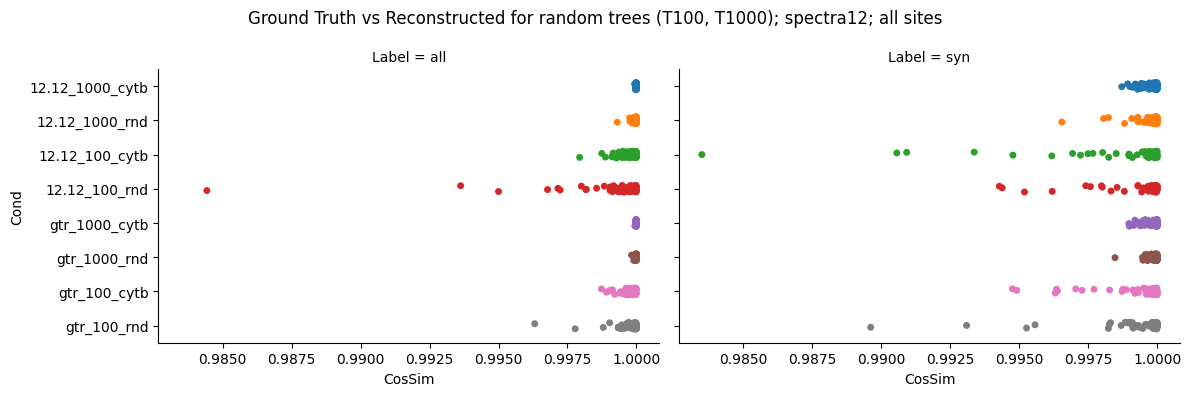

In [116]:
g = sns.catplot(x="CosSim", y="Cond", col="Label",
                data=sims, kind="strip",
                height=4, aspect=1.5);
g.fig.suptitle("Ground Truth vs Reconstructed for random trees (T100, T1000); spectra12; all sites")
g.fig.subplots_adjust(top=0.83)
plt.show()

### 12 excluding inv sites

In [117]:
nmuttypes = 12
param_rates = ""

data_rec  = []
data_gt  = []
for d in tqdm.tqdm(glob.glob("../data/alisim/spectra_reconstructed_sp" + param_rates + "/*")):
    elabel = d.split("/")[-1]
    path_to_rec = os.path.join(d, "mutspec_tables/ms{}{}_iqtree.tsv")
    path_to_gt = f"../data/alisim/spectra_groundtruth_sp{param_rates}/{elabel}/mutspec{nmuttypes}.tsv"
    
    if not os.path.exists(path_to_gt):
        # print(f"{elabel}:\n\t'{path_to_gt}' doesn't exist")
        pass
    elif not os.path.exists(path_to_rec.format(nmuttypes, "syn")):
        # print(f"{elabel}:\n\t'{path_to_rec.format('syn')}' doesn't exist")
        pass
    else:
        rec = pd.concat([
            pd.read_csv(path_to_rec.format(nmuttypes, "syn"), sep="\t").assign(Label="syn"),
            pd.read_csv(path_to_rec.format(nmuttypes, "all"), sep="\t").assign(Label="all"),
        ], ignore_index=True)
        gt = pd.read_csv(path_to_gt, sep="\t")
        gt = gt[gt.Label.isin(["all", "syn"])]\
            .groupby(["Label", "Mut"]).agg({"ObsNum": np.sum, "ExpNum": np.mean})
        gt["MutSpec"] = gt["ObsNum"]  / gt["ExpNum"]
        gt["MutSpec"] = gt["MutSpec"] / gt["MutSpec"].sum()

        rec = rec.assign(RawCond=elabel)
        gt = gt.reset_index().assign(RawCond=elabel)[rec.columns]
        data_rec.append(rec)
        data_gt.append(gt)

        # cossim = 1 - cosine(spectra.MutSpec_rec, spectra.MutSpec_gt)
        # eucdist = euclidean(spectra.MutSpec_rec, spectra.MutSpec_gt)
        # mdl, tree, aln, _, replica = elabel.split("_")
        # data.append((mdl, tree, aln, replica, cossim, eucdist, elabel))

100%|██████████| 799/799 [00:20<00:00, 38.67it/s]


In [118]:
df_rec = pd.concat(data_rec)
df_gt = pd.concat(data_gt)

_indexes = ["RawCond", "Label", "Mut"]
both_spectra = df_rec.merge(df_gt, on=_indexes, suffixes=["_rec", "_gt"])
both_spectra = both_spectra[_indexes + ['ObsNum_gt', 'ObsNum_rec','ExpNum_gt', 'ExpNum_rec', 'MutSpec_gt', 'MutSpec_rec']]

_df = both_spectra[
    (both_spectra.ExpNum_rec > 1) & (both_spectra.ExpNum_gt > 1) &
    (both_spectra.ObsNum_rec > 1) & (both_spectra.ObsNum_gt > 1)
].set_index(_indexes)

spectra_rec_wide = _df.MutSpec_rec.unstack().fillna(0.)
spectra_gt_wide = _df.MutSpec_gt.unstack().fillna(0.)

# obs_rec_wide = df_rec.set_index(["RawCond", "Label", "Mut"]).ObsNum.unstack().fillna(0.)
# obs_gt_wide = df_gt.set_index(["RawCond", "Label", "Mut"]).ObsNum.unstack().fillna(0.)

In [119]:
sims = get_cossim(spectra_gt_wide, spectra_rec_wide).rename("CosSim").reset_index()
sims["Cond"] = sims.RawCond.str.replace("_replica_\d{1,2}", "")
sims.head()

,RawCond,Label,CosSim,Cond
0,12.12_1000_cytb_replica_0,all,0.997648,12.12_1000_cytb
1,12.12_1000_cytb_replica_0,syn,0.993630,12.12_1000_cytb
2,12.12_1000_cytb_replica_1,all,0.998239,12.12_1000_cytb
3,12.12_1000_cytb_replica_1,syn,0.994501,12.12_1000_cytb
4,12.12_1000_cytb_replica_10,all,0.996364,12.12_1000_cytb


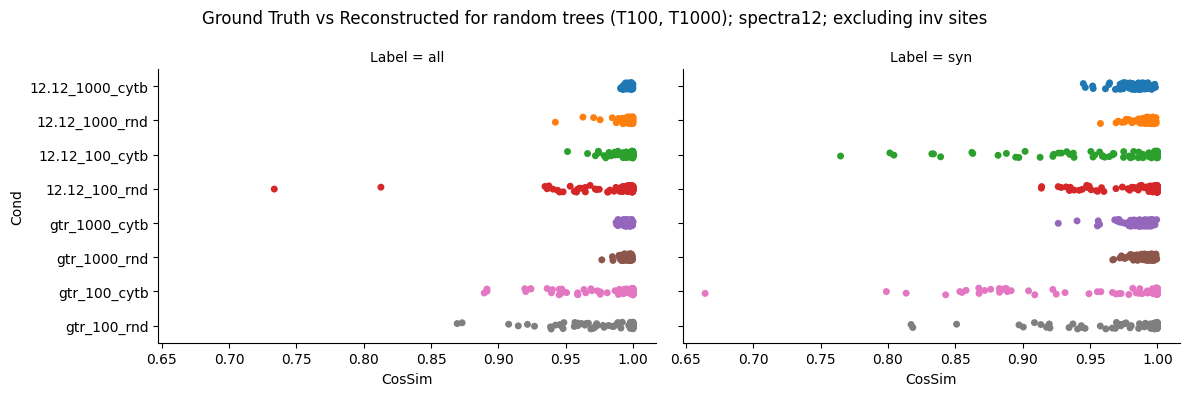

In [120]:
g = sns.catplot(x="CosSim", y="Cond", col="Label",
                data=sims, kind="strip",
                height=4, aspect=1.5);
g.fig.suptitle("Ground Truth vs Reconstructed for random trees (T100, T1000); spectra12; excluding inv sites")
g.fig.subplots_adjust(top=0.83)
plt.show()

In [121]:
cutoff = 0.95
sims[f"cossim > {cutoff}"] = sims.CosSim > cutoff
sims.groupby(["Cond", "Label"])[f"cossim > {cutoff}"].value_counts().unstack().fillna(0).T

Cond          12.12_1000_cytb       12.12_1000_rnd        12.12_100_cytb  \
Label                     all   syn            all    syn            all   
cossim > 0.95                                                              
False                     0.0   2.0            1.0    0.0            0.0   
True                    100.0  98.0           99.0  100.0          100.0   

Cond                12.12_100_rnd       gtr_1000_cytb       gtr_1000_rnd  \
Label           syn           all   syn           all   syn          all   
cossim > 0.95                                                              
False          22.0           9.0  13.0           0.0   2.0          0.0   
True           78.0          91.0  87.0          99.0  97.0        100.0   

Cond                 gtr_100_cytb       gtr_100_rnd        
Label            syn          all   syn         all   syn  
cossim > 0.95                                              
False            0.0         16.0  24.0        13.0  17.0  
True           100.0         84.0  76.0        87.0  83.0

In [122]:
cutoff = 0.85
sims[f"cossim > {cutoff}"] = sims.CosSim > cutoff
sims.groupby(["Cond", "Label"])[f"cossim > {cutoff}"].value_counts().unstack().fillna(0).T

Cond          12.12_1000_cytb        12.12_1000_rnd        12.12_100_cytb  \
Label                     all    syn            all    syn            all   
cossim > 0.85                                                               
False                     0.0    0.0            0.0    0.0            0.0   
True                    100.0  100.0          100.0  100.0          100.0   

Cond                12.12_100_rnd        gtr_1000_cytb       gtr_1000_rnd  \
Label           syn           all    syn           all   syn          all   
cossim > 0.85                                                               
False           6.0           2.0    0.0           0.0   0.0          0.0   
True           94.0          98.0  100.0          99.0  99.0        100.0   

Cond                 gtr_100_cytb       gtr_100_rnd        
Label            syn          all   syn         all   syn  
cossim > 0.85                                              
False            0.0          0.0   4.0         0.0   2.0  
True           100.0        100.0  96.0       100.0  98.0

### 192  all sites

In [123]:
nmuttypes = 192
param_rates = "_all_positions"

data_rec  = []
data_gt  = []
for d in tqdm.tqdm(glob.glob("../data/alisim/spectra_reconstructed_sp" + param_rates + "/*")):
    elabel = d.split("/")[-1]
    path_to_rec = os.path.join(d, "mutspec_tables/ms{}{}_iqtree.tsv")
    path_to_gt = f"../data/alisim/spectra_groundtruth_sp{param_rates}/{elabel}/mutspec{nmuttypes}.tsv"
    
    if not os.path.exists(path_to_gt):
        # print(f"{elabel}:\n\t'{path_to_gt}' doesn't exist")
        pass
    elif not os.path.exists(path_to_rec.format(nmuttypes, "syn")):
        # print(f"{elabel}:\n\t'{path_to_rec.format('syn')}' doesn't exist")
        pass
    else:
        rec = pd.concat([
            pd.read_csv(path_to_rec.format(nmuttypes, "syn"), sep="\t").assign(Label="syn"),
            pd.read_csv(path_to_rec.format(nmuttypes, "all"), sep="\t").assign(Label="all"),
        ], ignore_index=True)
        gt = pd.read_csv(path_to_gt, sep="\t")
        gt = gt[gt.Label.isin(["all", "syn"])]\
            .groupby(["Label", "Mut"]).agg({"ObsNum": np.sum, "ExpNum": np.mean})
        gt["MutSpec"] = gt["ObsNum"]  / gt["ExpNum"]
        gt["MutSpec"] = gt["MutSpec"] / gt["MutSpec"].sum()

        rec = rec.assign(RawCond=elabel)
        gt = gt.reset_index().assign(RawCond=elabel)[rec.columns]
        data_rec.append(rec)
        data_gt.append(gt)

        # cossim = 1 - cosine(spectra.MutSpec_rec, spectra.MutSpec_gt)
        # eucdist = euclidean(spectra.MutSpec_rec, spectra.MutSpec_gt)
        # mdl, tree, aln, _, replica = elabel.split("_")
        # data.append((mdl, tree, aln, replica, cossim, eucdist, elabel))

100%|██████████| 800/800 [02:49<00:00,  4.73it/s]


In [124]:
df_rec = pd.concat(data_rec)
df_gt = pd.concat(data_gt)

_indexes = ["RawCond", "Label", "Mut"]
both_spectra = df_rec.merge(df_gt, on=_indexes, suffixes=["_rec", "_gt"])
both_spectra = both_spectra[_indexes + ['ObsNum_gt', 'ObsNum_rec','ExpNum_gt', 'ExpNum_rec', 'MutSpec_gt', 'MutSpec_rec']]

_df = both_spectra[
    (both_spectra.ExpNum_rec > 1) & (both_spectra.ExpNum_gt > 1) &
    (both_spectra.ObsNum_rec > 1) & (both_spectra.ObsNum_gt > 1)
].set_index(_indexes)

spectra_rec_wide = complete_sbs192_columns(_df.MutSpec_rec.unstack().fillna(0.))
spectra_gt_wide = complete_sbs192_columns(_df.MutSpec_gt.unstack().fillna(0.))

# obs_rec_wide = df_rec.set_index(["RawCond", "Label", "Mut"]).ObsNum.unstack().fillna(0.)
# obs_gt_wide = df_gt.set_index(["RawCond", "Label", "Mut"]).ObsNum.unstack().fillna(0.)

In [125]:
sims = get_cossim(spectra_gt_wide, spectra_rec_wide).rename("CosSim").reset_index()
sims["Cond"] = sims.RawCond.str.replace("_replica_\d{1,2}", "")
sims.head()

,RawCond,Label,CosSim,Cond
0,12.12_1000_cytb_replica_0,all,0.999597,12.12_1000_cytb
1,12.12_1000_cytb_replica_0,syn,0.999602,12.12_1000_cytb
2,12.12_1000_cytb_replica_1,all,0.999738,12.12_1000_cytb
3,12.12_1000_cytb_replica_1,syn,0.999631,12.12_1000_cytb
4,12.12_1000_cytb_replica_10,all,0.999143,12.12_1000_cytb


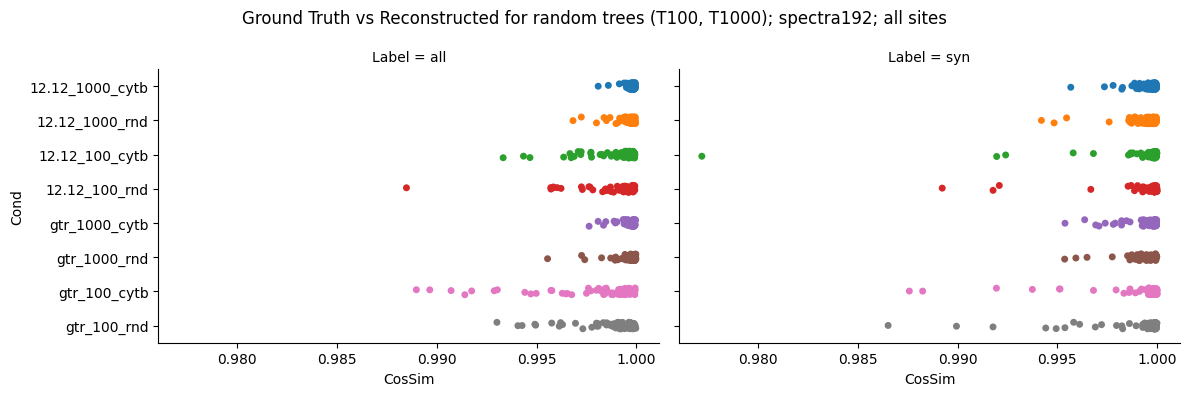

In [126]:
g = sns.catplot(x="CosSim", y="Cond", col="Label",
                data=sims, kind="strip",
                height=4, aspect=1.5);
g.fig.suptitle("Ground Truth vs Reconstructed for random trees (T100, T1000); spectra192; all sites")
g.fig.subplots_adjust(top=0.83)
plt.show()

### 192 excluding inv sites

In [127]:
nmuttypes = 192
param_rates = ""

data_rec  = []
data_gt  = []
for d in tqdm.tqdm(glob.glob("../data/alisim/spectra_reconstructed_sp" + param_rates + "/*")):
    elabel = d.split("/")[-1]
    path_to_rec = os.path.join(d, "mutspec_tables/ms{}{}_iqtree.tsv")
    path_to_gt = f"../data/alisim/spectra_groundtruth_sp{param_rates}/{elabel}/mutspec{nmuttypes}.tsv"
    
    if not os.path.exists(path_to_gt):
        # print(f"{elabel}:\n\t'{path_to_gt}' doesn't exist")
        pass
    elif not os.path.exists(path_to_rec.format(nmuttypes, "syn")):
        # print(f"{elabel}:\n\t'{path_to_rec.format('syn')}' doesn't exist")
        pass
    else:
        rec = pd.concat([
            pd.read_csv(path_to_rec.format(nmuttypes, "syn"), sep="\t").assign(Label="syn"),
            pd.read_csv(path_to_rec.format(nmuttypes, "all"), sep="\t").assign(Label="all"),
        ], ignore_index=True)
        gt = pd.read_csv(path_to_gt, sep="\t")
        gt = gt[gt.Label.isin(["all", "syn"])]\
            .groupby(["Label", "Mut"]).agg({"ObsNum": np.sum, "ExpNum": np.mean})
        gt["MutSpec"] = gt["ObsNum"]  / gt["ExpNum"]
        gt["MutSpec"] = gt["MutSpec"] / gt["MutSpec"].sum()

        rec = rec.assign(RawCond=elabel)
        gt = gt.reset_index().assign(RawCond=elabel)[rec.columns]
        data_rec.append(rec)
        data_gt.append(gt)

        # cossim = 1 - cosine(spectra.MutSpec_rec, spectra.MutSpec_gt)
        # eucdist = euclidean(spectra.MutSpec_rec, spectra.MutSpec_gt)
        # mdl, tree, aln, _, replica = elabel.split("_")
        # data.append((mdl, tree, aln, replica, cossim, eucdist, elabel))

  0%|          | 0/799 [00:00<?, ?it/s]

100%|██████████| 799/799 [03:20<00:00,  3.98it/s]


In [128]:
df_rec = pd.concat(data_rec)
df_gt = pd.concat(data_gt)

_indexes = ["RawCond", "Label", "Mut"]
both_spectra = df_rec.merge(df_gt, on=_indexes, suffixes=["_rec", "_gt"])
both_spectra = both_spectra[_indexes + ['ObsNum_gt', 'ObsNum_rec','ExpNum_gt', 'ExpNum_rec', 'MutSpec_gt', 'MutSpec_rec']]

_df = both_spectra[
    (both_spectra.ExpNum_rec > 1) & (both_spectra.ExpNum_gt > 1) &
    (both_spectra.ObsNum_rec > 1) & (both_spectra.ObsNum_gt > 1)
].set_index(_indexes)

spectra_rec_wide = complete_sbs192_columns(_df.MutSpec_rec.unstack().fillna(0.))
spectra_gt_wide = complete_sbs192_columns(_df.MutSpec_gt.unstack().fillna(0.))

# obs_rec_wide = df_rec.set_index(["RawCond", "Label", "Mut"]).ObsNum.unstack().fillna(0.)
# obs_gt_wide = df_gt.set_index(["RawCond", "Label", "Mut"]).ObsNum.unstack().fillna(0.)

In [129]:
sims = get_cossim(spectra_gt_wide, spectra_rec_wide).rename("CosSim").reset_index()
sims["Cond"] = sims.RawCond.str.replace("_replica_\d{1,2}", "")
sims.head()

,RawCond,Label,CosSim,Cond
0,12.12_1000_cytb_replica_0,all,0.978823,12.12_1000_cytb
1,12.12_1000_cytb_replica_0,syn,0.947532,12.12_1000_cytb
2,12.12_1000_cytb_replica_1,all,0.951463,12.12_1000_cytb
3,12.12_1000_cytb_replica_1,syn,0.947053,12.12_1000_cytb
4,12.12_1000_cytb_replica_10,all,0.961942,12.12_1000_cytb


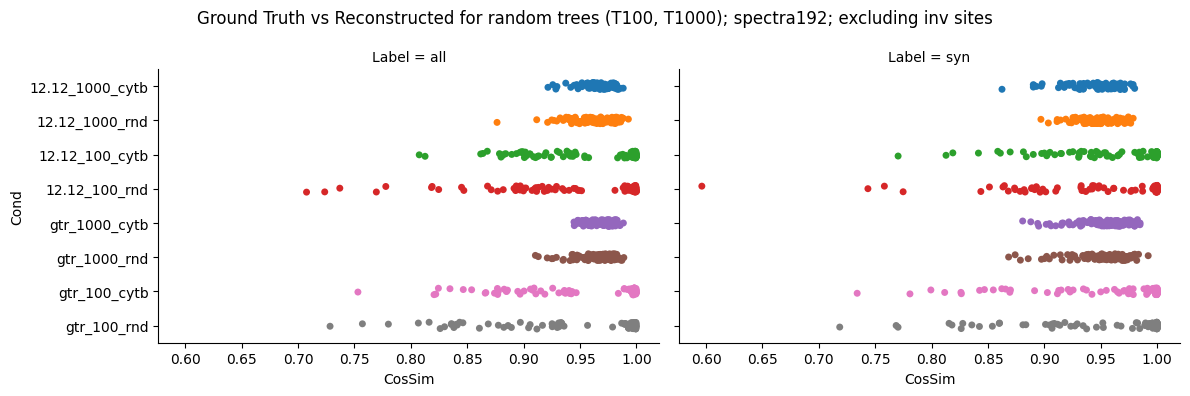

In [130]:
g = sns.catplot(x="CosSim", y="Cond", col="Label",
                data=sims, kind="strip",
                height=4, aspect=1.5);
g.fig.suptitle("Ground Truth vs Reconstructed for random trees (T100, T1000); spectra192; excluding inv sites")
g.fig.subplots_adjust(top=0.83)
plt.show()

In [131]:
cutoff = 0.95
sims[f"cossim > {cutoff}"] = sims.CosSim > cutoff
sims.groupby(["Cond", "Label"])[f"cossim > {cutoff}"].value_counts().unstack().fillna(0).T

Cond          12.12_1000_cytb     12.12_1000_rnd     12.12_100_cytb      \
Label                     all syn            all syn            all syn   
cossim > 0.95                                                             
False                      10  56             24  56             41  31   
True                       90  44             76  44             59  69   

Cond          12.12_100_rnd     gtr_1000_cytb     gtr_1000_rnd      \
Label                   all syn           all syn          all syn   
cossim > 0.95                                                        
False                    42  34             6  42           17  36   
True                     58  66            93  57           83  64   

Cond          gtr_100_cytb     gtr_100_rnd      
Label                  all syn         all syn  
cossim > 0.95                                   
False                   36  25          36  28  
True                    64  75          64  71

In [132]:
cutoff = 0.85
sims[f"cossim > {cutoff}"] = sims.CosSim > cutoff
sims.groupby(["Cond", "Label"])[f"cossim > {cutoff}"].value_counts().unstack().fillna(0).T

Cond          12.12_1000_cytb        12.12_1000_rnd        12.12_100_cytb  \
Label                     all    syn            all    syn            all   
cossim > 0.85                                                               
False                     0.0    0.0            0.0    0.0            2.0   
True                    100.0  100.0          100.0  100.0           98.0   

Cond                12.12_100_rnd       gtr_1000_cytb       gtr_1000_rnd  \
Label           syn           all   syn           all   syn          all   
cossim > 0.85                                                              
False           4.0          10.0   5.0           0.0   0.0          0.0   
True           96.0          90.0  95.0          99.0  99.0        100.0   

Cond                 gtr_100_cytb       gtr_100_rnd        
Label            syn          all   syn         all   syn  
cossim > 0.85                                              
False            0.0          6.0   8.0        15.0   9.0  
True           100.0         94.0  92.0        85.0  90.0

In [5]:
nmuttypes = 192

data_rec  = []
data_gt  = []
for d in tqdm.tqdm(glob.glob("../data/alisim/spectra_reconstructed_sp/*")):
    elabel = d.split("/")[-1]
    path_to_rec = os.path.join(d, "mutspec_tables/ms{nmuttypes}{}_iqtree.tsv")
    path_to_gt = f"../data/alisim/spectra_groundtruth_sp/{elabel}/mutspec{nmuttypes}.tsv"
    
    if not os.path.exists(path_to_gt):
        # print(f"{elabel}:\n\t'{path_to_gt}' doesn't exist")
        pass
    elif not os.path.exists(path_to_rec.format(nmuttypes, "syn")):
        # print(f"{elabel}:\n\t'{path_to_rec.format('syn')}' doesn't exist")
        pass
    else:
        rec = pd.concat([
            pd.read_csv(path_to_rec.format(nmuttypes, "syn"), sep="\t").assign(Label="syn"),
            pd.read_csv(path_to_rec.format(nmuttypes, "all"), sep="\t").assign(Label="all"),
        ], ignore_index=True)
        gt = pd.read_csv(path_to_gt, sep="\t")
        gt = gt[gt.Label.isin(["all", "syn"])]\
            .groupby(["Label", "Mut"]).agg({"ObsNum": np.sum, "ExpNum": np.mean})
        gt["MutSpec"] = gt["ObsNum"]  / gt["ExpNum"]
        gt["MutSpec"] = gt["MutSpec"] / gt["MutSpec"].sum()

        rec = rec.assign(RawCond=elabel)
        gt = gt.reset_index().assign(RawCond=elabel)[rec.columns]
        data_rec.append(rec)
        data_gt.append(gt)

        # cossim = 1 - cosine(spectra.MutSpec_rec, spectra.MutSpec_gt)
        # eucdist = euclidean(spectra.MutSpec_rec, spectra.MutSpec_gt)
        # mdl, tree, aln, _, replica = elabel.split("_")
        # data.append((mdl, tree, aln, replica, cossim, eucdist, elabel))

100%|██████████| 800/800 [03:15<00:00,  4.10it/s]


### EXP check in

In [4]:
# coda = CodonAnnotation(2)
# cat_cutoff = 1

# data_exp_rec = []
# for d in tqdm.tqdm(glob.glob("../data/alisim/spectra_reconstructed_sp/*")):
#     elabel = d.split("/")[-1]
#     path_to_rec_exp = os.path.join(d, "sequences/alignment_checked.fasta")
#     cats = read_rates(os.path.join(d, "IQTREE/anc.rate"))
#     mask = np.array(cats) >= cat_cutoff
#     raw_exp_data = []
#     for rec in SeqIO.parse(path_to_rec_exp, "fasta"):
#         _, cur_exp_freqs192 = coda.collect_exp_mut_freqs(str(rec.seq), mask, labels=["all", "syn"])
#         cur_exp_freqs192 = pd.DataFrame(cur_exp_freqs192).T
#         raw_exp_data.append(cur_exp_freqs192)
#     data_exp_rec.append(
#         pd.concat(raw_exp_data).mean(level=0).assign(RawCond=elabel).set_index("RawCond")
#     ) 


In [6]:
data_exp_rec = []
for path_to_rec_exp in tqdm.tqdm(glob.glob("../data/alisim/spectra_reconstructed_sp/*/mutspec_tables/expected_mutations.tsv")):
    raw_cond = path_to_rec_exp.split("/")[-3]
    cur_exp = pd.read_csv(path_to_rec_exp, sep="\t", usecols=["Pos", "Mut", "Proba", "Label"]).assign(RawCond=raw_cond)
    data_exp_rec.append(cur_exp)


  0%|          | 0/800 [00:00<?, ?it/s]

100%|██████████| 800/800 [14:47<00:00,  1.11s/it]


In [8]:
exp_rec = pd.concat(data_exp_rec)

In [9]:
exp_rec.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2102058112 entries, 0 to 5011945
Data columns (total 5 columns):
 #   Column   Dtype  
---  ------   -----  
 0   Pos      int64  
 1   Mut      object 
 2   Label    object 
 3   Proba    float64
 4   RawCond  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 94.0+ GB


In [75]:
pd.concat(raw_exp_data).mean(level=0)

,T[C>T]A,C[A>G]G,C[A>C]G,C[A>T]G,C[T>C]T,A[C>T]A,G[G>T]C,G[G>A]C,G[G>C]C,C[A>G]A,...,A[A>T]T,A[A>C]G,A[A>G]G,A[A>T]G,G[A>T]A,G[A>C]A,G[A>G]A,A[T>A]G,A[T>C]G,A[T>G]G
syn,2.109,3.229,3.229,3.229,6.107,2.914,8.845,10.764,8.845,1.221203,...,NaN,NaN,1.017143,NaN,1.005219,1.005219,1.007307,NaN,1.022951,NaN
all,6.166,10.404,10.404,10.404,12.168,4.211,18.862,18.862,18.862,4.241000,...,1.15736,2.365,2.365000,2.365,1.277890,1.277890,1.277890,2.353353,2.353353,2.353353


### OBS

In [6]:
df_rec = pd.concat(data_rec)
df_gt = pd.concat(data_gt)

df_rec["Cond"] = df_rec.RawCond.str.replace("_replica_\d{1,2}", "")
df_gt["Cond"] = df_gt.RawCond.str.replace("_replica_\d{1,2}", "")

spectra_rec_wide = complete_sbs192_columns(df_rec.set_index(["RawCond", "Label", "Mut"]).MutSpec.unstack()).fillna(0.)
spectra_gt_wide = complete_sbs192_columns(df_gt.set_index(["RawCond", "Label", "Mut"]).MutSpec.unstack()).fillna(0.)

obs_rec_wide = complete_sbs192_columns(df_rec.set_index(["RawCond", "Label", "Mut"]).ObsNum.unstack()).fillna(0.)
obs_gt_wide = complete_sbs192_columns(df_gt.set_index(["RawCond", "Label", "Mut"]).ObsNum.unstack()).fillna(0.)

### Similarity by spectra

In [7]:
sims = get_cossim(spectra_gt_wide, spectra_rec_wide).rename("CosSim").reset_index()
sims["Cond"] = sims.RawCond.str.replace("_replica_\d{1,2}", "")
sims.head()

,RawCond,Label,CosSim,Cond
0,12.12_1000_cytb_replica_0,all,0.921865,12.12_1000_cytb
1,12.12_1000_cytb_replica_0,syn,0.793366,12.12_1000_cytb
2,12.12_1000_cytb_replica_1,all,0.946197,12.12_1000_cytb
3,12.12_1000_cytb_replica_1,syn,0.813312,12.12_1000_cytb
4,12.12_1000_cytb_replica_10,all,0.961919,12.12_1000_cytb


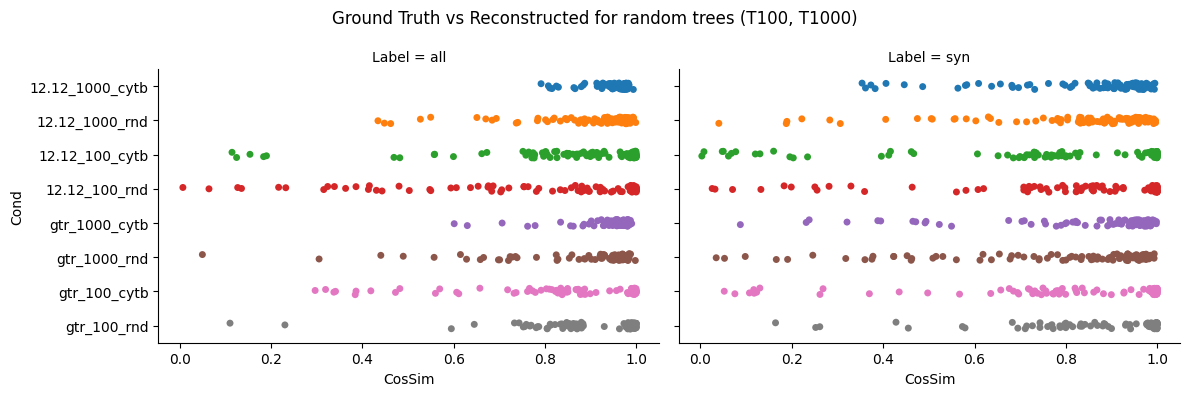

In [8]:
g = sns.catplot(x="CosSim", y="Cond", col="Label",
                data=sims, kind="strip",
                height=4, aspect=1.5);
g.fig.suptitle("Ground Truth vs Reconstructed for random trees (T100, T1000)")
g.fig.subplots_adjust(top=0.83)
plt.show()

In [9]:
cutoff = 0.95
sims[f"cossim > {cutoff}"] = sims.CosSim > cutoff
sims.groupby(["Cond", "Label"])[f"cossim > {cutoff}"].value_counts().unstack()

cossim > 0.95          False  True
Cond            Label             
12.12_1000_cytb all       34    66
                syn       63    37
12.12_1000_rnd  all       51    49
                syn       71    29
12.12_100_cytb  all       55    45
                syn       56    44
12.12_100_rnd   all       58    42
                syn       55    45
gtr_1000_cytb   all       25    75
                syn       56    44
gtr_1000_rnd    all       46    54
                syn       71    29
gtr_100_cytb    all       48    52
                syn       48    52
gtr_100_rnd     all       44    56
                syn       42    58

In [10]:
cutoff = 0.85
sims[f"cossim > {cutoff}"] = sims.CosSim > cutoff
sims.groupby(["Cond", "Label"])[f"cossim > {cutoff}"].value_counts().unstack()

cossim > 0.85          False  True
Cond            Label             
12.12_1000_cytb all        6    94
                syn       27    73
12.12_1000_rnd  all       21    79
                syn       39    61
12.12_100_cytb  all       33    67
                syn       53    47
12.12_100_rnd   all       39    61
                syn       39    61
gtr_1000_cytb   all        6    94
                syn       27    73
gtr_1000_rnd    all       20    80
                syn       40    60
gtr_100_cytb    all       36    64
                syn       41    59
gtr_100_rnd     all       27    73
                syn       30    70

### Similarity by observed mutation counts

In [11]:
sims = get_cossim(obs_gt_wide, obs_rec_wide).rename("CosSim").reset_index()
sims["Cond"] = sims.RawCond.str.replace("_replica_\d{1,2}", "")
sims.head()

,RawCond,Label,CosSim,Cond
0,12.12_1000_cytb_replica_0,all,0.999845,12.12_1000_cytb
1,12.12_1000_cytb_replica_0,syn,0.999496,12.12_1000_cytb
2,12.12_1000_cytb_replica_1,all,0.999924,12.12_1000_cytb
3,12.12_1000_cytb_replica_1,syn,0.999687,12.12_1000_cytb
4,12.12_1000_cytb_replica_10,all,0.999878,12.12_1000_cytb


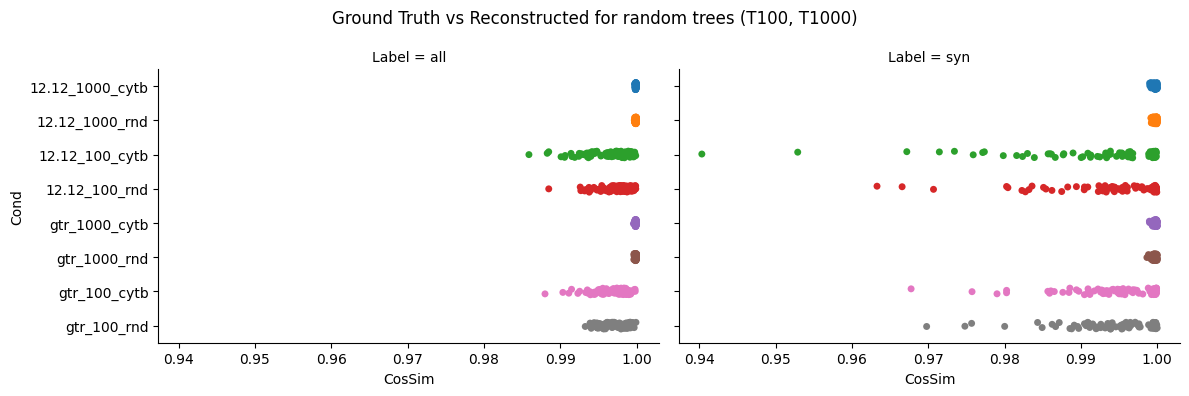

In [12]:
g = sns.catplot(x="CosSim", y="Cond", col="Label",
                data=sims, kind="strip",
                height=4, aspect=1.5);
g.fig.suptitle("Ground Truth vs Reconstructed for random trees (T100, T1000)")
g.fig.subplots_adjust(top=0.83)
plt.show()

## Random species trees all positions

In [16]:
data_rec  = []
data_gt  = []
for d in tqdm.tqdm(glob.glob("../data/alisim/spectra_reconstructed_sp_all_positions/*")):
    elabel = d.split("/")[-1]
    path_to_rec = os.path.join(d, "mutspec_tables/ms192{}_iqtree.tsv")
    path_to_gt = f"../data/alisim/spectra_groundtruth_sp_all_positions/{elabel}/mutspec192.tsv"
    
    if not os.path.exists(path_to_gt):
        # print(f"{elabel}:\n\t'{path_to_gt}' doesn't exist")
        pass
    elif not os.path.exists(path_to_rec.format("syn")):
        # print(f"{elabel}:\n\t'{path_to_rec.format('syn')}' doesn't exist")
        pass
    else:
        rec = pd.concat([
            pd.read_csv(path_to_rec.format("syn"), sep="\t").assign(Label="syn"),
            pd.read_csv(path_to_rec.format("all"), sep="\t").assign(Label="all"),
        ], ignore_index=True)
        gt = pd.read_csv(path_to_gt, sep="\t")
        gt = gt[gt.Label.isin(["all", "syn"])]\
            .groupby(["Label", "Mut"]).agg({"ObsNum": np.sum, "ExpNum": np.mean})
        gt["MutSpec"] = gt["ObsNum"]  / gt["ExpNum"]
        gt["MutSpec"] = gt["MutSpec"] / gt["MutSpec"].sum()

        rec = rec.assign(RawCond=elabel)
        gt = gt.reset_index().assign(RawCond=elabel)[rec.columns]
        data_rec.append(rec)
        data_gt.append(gt)

        # cossim = 1 - cosine(spectra.MutSpec_rec, spectra.MutSpec_gt)
        # eucdist = euclidean(spectra.MutSpec_rec, spectra.MutSpec_gt)
        # mdl, tree, aln, _, replica = elabel.split("_")
        # data.append((mdl, tree, aln, replica, cossim, eucdist, elabel))

100%|██████████| 800/800 [03:45<00:00,  3.54it/s]


In [17]:
df_rec2 = pd.concat(data_rec)
df_gt2 = pd.concat(data_gt)

df_rec2["Cond"] = df_rec2.RawCond.str.replace("_replica_\d{1,2}", "")
df_gt2["Cond"] = df_gt2.RawCond.str.replace("_replica_\d{1,2}", "")

spectra_rec_wide2 = complete_sbs192_columns(df_rec2.set_index(["RawCond", "Label", "Mut"]).MutSpec.unstack()).fillna(0.)
spectra_gt_wide2 = complete_sbs192_columns(df_gt2.set_index(["RawCond", "Label", "Mut"]).MutSpec.unstack()).fillna(0.)

obs_rec_wide2 = complete_sbs192_columns(df_rec2.set_index(["RawCond", "Label", "Mut"]).ObsNum.unstack()).fillna(0.)
obs_gt_wide2 = complete_sbs192_columns(df_gt2.set_index(["RawCond", "Label", "Mut"]).ObsNum.unstack()).fillna(0.)

### Similarity by spectra

In [30]:
sims = get_cossim(spectra_gt_wide2, spectra_rec_wide2).rename("CosSim").reset_index()
sims["Cond"] = sims.RawCond.str.replace("_replica_\d{1,2}", "")
sims.head()

,RawCond,Label,CosSim,Cond
0,12.12_1000_cytb_replica_0,all,0.999514,12.12_1000_cytb
1,12.12_1000_cytb_replica_0,syn,0.829184,12.12_1000_cytb
2,12.12_1000_cytb_replica_1,all,0.999738,12.12_1000_cytb
3,12.12_1000_cytb_replica_1,syn,0.996152,12.12_1000_cytb
4,12.12_1000_cytb_replica_10,all,0.999116,12.12_1000_cytb


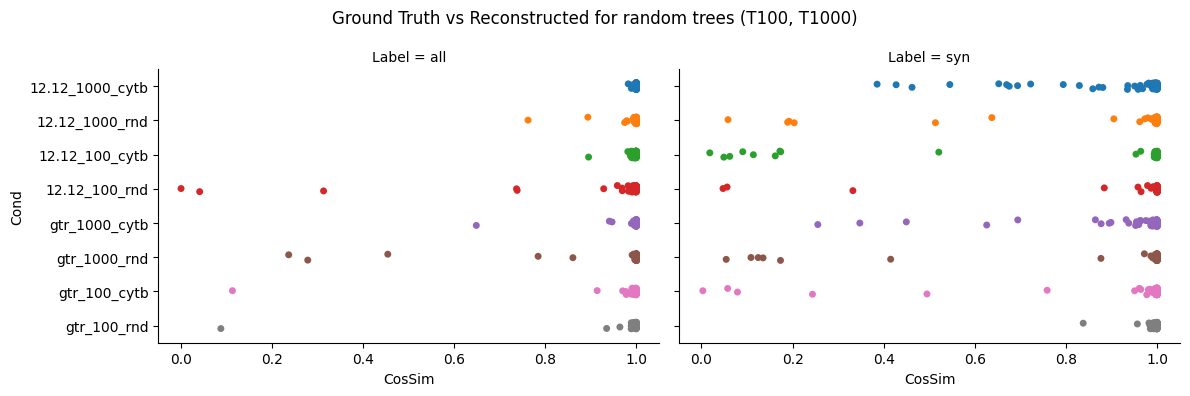

In [19]:
g = sns.catplot(x="CosSim", y="Cond", col="Label",
                data=sims, kind="strip",
                height=4, aspect=1.5);
g.fig.suptitle("Ground Truth vs Reconstructed for random trees (T100, T1000)")
g.fig.subplots_adjust(top=0.83)
plt.show()

In [43]:
_indexes = ["RawCond", "Cond", "Label", "Mut"]
both_spectra = df_rec2.merge(df_gt2, on=_indexes, suffixes=["_rec", "_gt"]).merge(sims, on=_indexes[:-1])
both_spectra = both_spectra[_indexes + ['ObsNum_gt', 'ObsNum_rec','ExpNum_gt', 'ExpNum_rec', 'MutSpec_gt', 'MutSpec_rec',  'CosSim',]]\
    .sort_values(["CosSim"] + _indexes)
both_spectra.head()

,RawCond,Cond,Label,Mut,ObsNum_gt,ObsNum_rec,ExpNum_gt,ExpNum_rec,MutSpec_gt,MutSpec_rec,CosSim
130417,12.12_100_rnd_replica_79,12.12_100_rnd,all,A[A>C]A,0,0.0,0.000000,0.000000,NaN,0.0,0.00083
130507,12.12_100_rnd_replica_79,12.12_100_rnd,all,A[A>C]C,0,0.0,0.000000,0.000000,NaN,0.0,0.00083
130446,12.12_100_rnd_replica_79,12.12_100_rnd,all,A[A>C]G,0,0.0,0.000000,0.000000,NaN,0.0,0.00083
130502,12.12_100_rnd_replica_79,12.12_100_rnd,all,A[A>C]T,0,0.0,0.009524,0.016903,0.0,0.0,0.00083
130468,12.12_100_rnd_replica_79,12.12_100_rnd,all,A[A>G]A,0,0.0,0.000000,0.000000,NaN,0.0,0.00083


In [35]:
both_spectra.loc[sims.set_index(["RawCond", "Label"]).sort_values(["CosSim"]).head(1).index]

ValueError: operands could not be broadcast together with shapes (1,2) (3,) (1,2) 